In [1]:
from scipy.special import iv
import math
import numpy as np
from IPython.display import Image
#Non dimensional parameters
#Mean potential input 
E_in=0
E0=1
eta=E_in-E0
Delta=3
k_0=1
alpha=0.55

The parameter estimation in Chris Bell's paper requires using the amplitudes of the harmonics. He provides equations to calculate these ampltidues analytically, where $m$ is the harmonic number, $I_0$ is a modified 0th order Bessel function and $\eta$ is $E_{in}-E_0$. There are two different expressions for the ampltitude in the paper, one of which has has used in his acutal implementation, a dimensional and a non-dimensional version. 


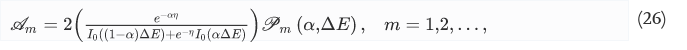

In [2]:
Image(filename = "amp_eq_1.png")


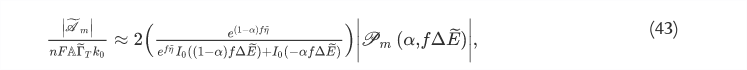

In [3]:
Image(filename = "amp_eq_2.png")


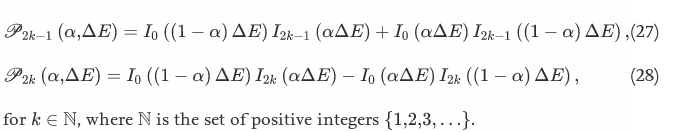

In [4]:
Image(filename="p_m_eq.png")

In [5]:
#Chris Bell's implementation, converted into python
#He uses a non-dimensional form of equation 43, which is different from equation 26
#The "P_k" function is also different (the order of the arguments is reversed)
A2act=(2*np.exp((1-alpha)*eta)/(np.exp(eta)*iv(0,(1-alpha)*Delta)+iv(0,-alpha*Delta))*abs(iv(0,alpha*Delta)*iv(2,(1-alpha)*Delta)-iv(0,(1-alpha)*Delta)*iv(2,alpha*Delta)))
A3act=(2*np.exp((1-alpha)*eta)/(np.exp(eta)*iv(0,(1-alpha)*Delta)+iv(0,-alpha*Delta))*abs(iv(0,alpha*Delta)*iv(3,(1-alpha)*Delta)+iv(0,(1-alpha)*Delta)*iv(3,alpha*Delta)))
A4act=(2*np.exp((1-alpha)*eta)/(np.exp(eta)*iv(0,(1-alpha)*Delta)+iv(0,-alpha*Delta))*abs(iv(0,alpha*Delta)*iv(4,(1-alpha)*Delta)-iv(0,(1-alpha)*Delta)*iv(4,alpha*Delta)))
#Just to be sure, here's the matlab implementation that I have just directly copied
#A2act=(2*exp((1-alpha)*eta)/(exp(eta)*besseli(0,(1-alpha)*Delta)+besseli(0,-alpha*Delta))*abs(besseli(0,alpha*Delta)*besseli(2,(1-alpha)*Delta)-besseli(0,(1-alpha)*Delta)*besseli(2,alpha*Delta)))
#A3act=(2*exp((1-alpha)*eta)/(exp(eta)*besseli(0,(1-alpha)*Delta)+besseli(0,-alpha*Delta))*abs(besseli(0,alpha*Delta)*besseli(3,(1-alpha)*Delta)+besseli(0,(1-alpha)*Delta)*besseli(3,alpha*Delta)))
#A4act=(2*exp((1-alpha)*eta)/(exp(eta)*besseli(0,(1-alpha)*Delta)+besseli(0,-alpha*Delta))*abs(besseli(0,alpha*Delta)*besseli(4,(1-alpha)*Delta)-besseli(0,(1-alpha)*Delta)*besseli(4,alpha*Delta)))

In [6]:
#A potentially easier to read implementation
def Harmonic_amp(m, **kwargs):
    alpha=kwargs["alpha"]
    Delta=kwargs["Delta"]
    eta=kwargs["eta"]
    numerator=2*np.exp((1-alpha)*eta)
    denominator=(np.exp(eta)*iv(0,(1-alpha)*Delta)+iv(0,-alpha*Delta))
    
    return (numerator/denominator)*abs(p_k(m, alpha, Delta, eta))
def p_k(m, alpha, Delta, eta):
    if m%2==0:
        p_k=(iv(0,(alpha*Delta))*iv(m,(1-alpha)*Delta))-(iv(0,(1-alpha)*Delta)*iv(m,(alpha)*Delta))
    elif m%2==1:
        p_k=(iv(0,(alpha*Delta))*iv(m,(1-alpha)*Delta))+(iv(0,(1-alpha)*Delta)*iv(m,(alpha)*Delta))
    return p_k

#Checking tht the function and CBs expression are the same
CB_amps=[A2act, A3act, A4act]
for m in range(0, 3):
    print(CB_amps[m], Harmonic_amp(m+2, alpha=alpha, Delta=Delta, eta=eta))


0.08828540853943731 0.08828540853943731
0.14618825567937857 0.14618825567937857
0.008779269015061835 0.008779269015061835


In the appendix to the paper, they provide some non-dimensional parameters, and expected harmonic amplitudes

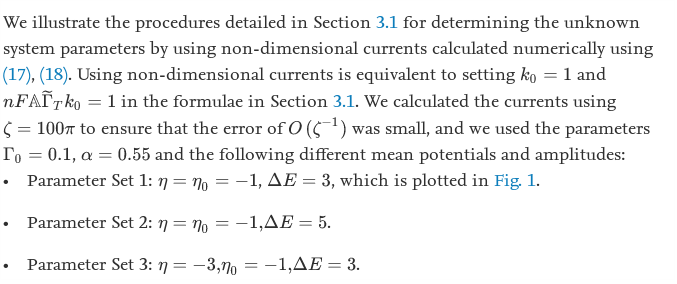

In [7]:
Image(filename="Param_set.png")

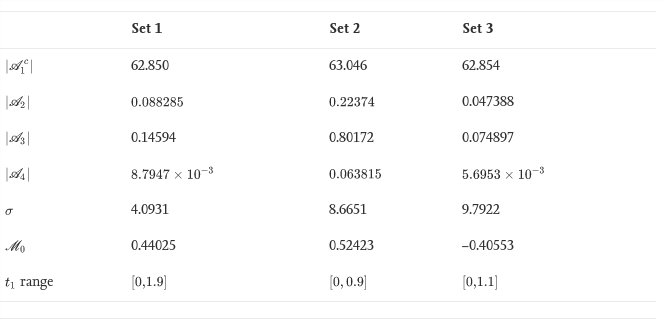

In [8]:
Image(filename="Amplitude_table.png")


In [9]:
param_sets={"Set1":{"alpha":0.55, "Delta":3, "eta":-1},
            "Set2":{"alpha":0.55, "Delta":5, "eta":-1},
            "Set3":{"alpha":0.55, "Delta":3, "eta":-3}}

param_keys=["Set"+str(i) for i in range(1, 4)]
amplitudes=np.zeros((3, len(param_keys)))


for i in range(0, 3):
    for j in range(0, len(param_keys)):
        amplitudes[i][j]=Harmonic_amp(i+2, **param_sets[param_keys[j]])
print(amplitudes)

for i in range(0, len(amplitudes)):
    print("Ampltidue "+str(i+2), amplitudes[i])
    

[[0.08828541 0.21930975 0.04506237]
 [0.14618826 0.80266455 0.07461696]
 [0.00877927 0.06236556 0.00448109]]
Ampltidue 2 [0.08828541 0.21930975 0.04506237]
Ampltidue 3 [0.14618826 0.80266455 0.07461696]
Ampltidue 4 [0.00877927 0.06236556 0.00448109]


So the amplitudes are slightly different, and I really do not know why. Changing the Harmonbic_amp() function so it reflects equation (26) rather than equation 43 makes the outputted amplitudes even more different! With this confusion in mind, we move on to the method of inferring $E^0$ and $k_0$ from two experiments with different input parameters (using the parameters defined by the paper above). There's also a method for doing it using the transient, but as we throw the transient away I thouhgt it would be better to use this method. Here's the expression (expressed in dimensional terms):

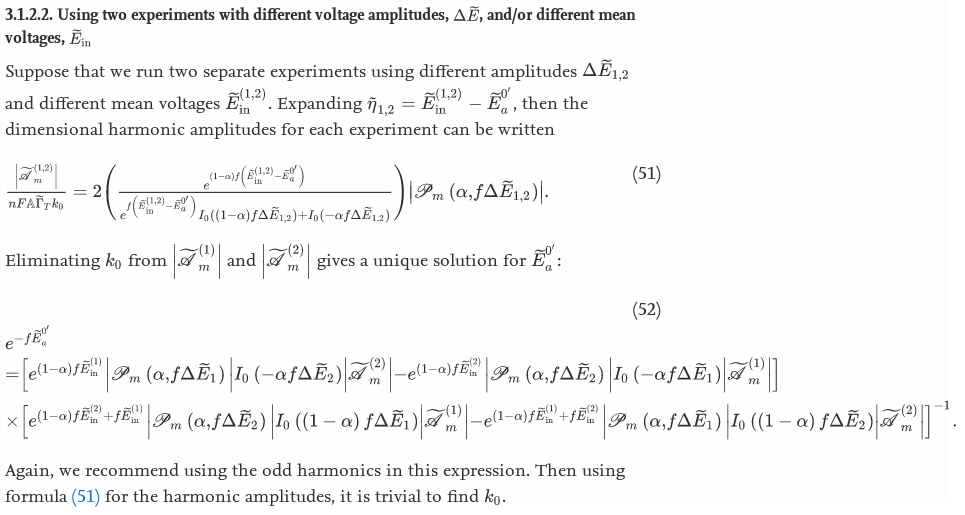

In [10]:
Image(filename="Inferring_params.png")

As an aside, I don't understand why he gives this equation in dimensional terms when the example is non-dimensional...

In [15]:
import itertools
import copy
Henry_amplitudes=[
    [0.08828541, 0.21930975, 0.04506237,],
    [0.14618826, 0.80266455, 0.07461696,],
    [0.00877927, 0.06236556, 0.00448109,],]
Bell_paper_amplitudes=[
    [0.088285, 0.22374, 0.043788],
    [0.14594, 0.80172, 0.074897],
    [8.7947e-3, 0.063815, 5.6953e-3]]       
param_sets_2={"Set1":{"alpha":0.55, "Delta":3, "eta":-1, "E_in":0},
            "Set2":{"alpha":0.55, "Delta":5, "eta":-1, "E_in":0},
            "Set3":{"alpha":0.55, "Delta":3, "eta":-3, "E_in":-2}}
param_keys=["Set"+str(i) for i in range(1, 4)]


def nd_param_estimator(m, amp_1, amp_2, **kwargs):
    alpha=kwargs["alpha"]
    dE1=kwargs["Delta1"]
    eta1=kwargs["eta1"]
    dE2=kwargs["Delta2"]
    eta2=kwargs["eta2"]
    E_in_1=kwargs["E_in_1"]
    E_in_2=kwargs["E_in_2"]
    p_k_de1=abs(p_k(m, alpha, dE1, eta1))
    p_k_de2=abs(p_k(m, alpha, dE2, eta2))
    arg1=np.exp((1-alpha)*E_in_1)*p_k_de1*iv(0, -alpha*dE2)*amp_2
    arg2=np.exp((1-alpha)*E_in_2)*p_k_de2*iv(0, -alpha*dE1)*amp_1
    arg3=np.exp((1-alpha)*(E_in_1+E_in_2))*p_k_de2*iv(0, (1-alpha)*dE1)*amp_1
    arg4=np.exp((1-alpha)*(E_in_1+E_in_2))*p_k_de1*iv(0, (1-alpha)*dE2)*amp_2
    RHS=(arg1-arg2)/(arg3-arg4)
    if RHS>0:
        E0_estimate=-np.log(RHS)
    else:
        E0_estimate=None
    return E0_estimate


combinations=list(itertools.combinations(range(0, 3),2))
table_title=[param_keys[x[0]]+"+"+param_keys[x[1]] for x in combinations]
print(table_title)
for harmonic in range(2, 5):
    harmonic_index=harmonic-2
    
    amplitudes=Henry_amplitudes
    E0_estimates=np.zeros(len(combinations))
    for i in range(0, len(combinations)):
        exp_1_idx=combinations[i][0]
        exp_2_idx=combinations[i][1]
        amp_1=amplitudes[harmonic_index][exp_1_idx]
        amp_2=amplitudes[harmonic_index][exp_2_idx]
        E0=nd_param_estimator(harmonic, 
                                amp_1, amp_2,
                                Delta1=param_sets_2[param_keys[exp_1_idx]]["Delta"],
                                Delta2=param_sets_2[param_keys[exp_2_idx]]["Delta"],
                                eta1=param_sets_2[param_keys[exp_1_idx]]["eta"],
                                eta2=param_sets_2[param_keys[exp_2_idx]]["eta"],
                                E_in_1=param_sets_2[param_keys[exp_1_idx]]["E_in"],
                                E_in_2=param_sets_2[param_keys[exp_2_idx]]["E_in"],
                                alpha=param_sets_2[param_keys[exp_1_idx]]["alpha"],
                             )
        E0_estimates[i]=E0
    print(E0_estimates)

['Set1+Set2', 'Set1+Set3', 'Set2+Set3']
[1.00000015 0.47201143 0.30969326]
[1.00000078 0.47201193 0.30969373]
[1.00000459 0.47200909 0.30968919]


So it's inconsistent between the parameter combinations, and only one of them reach the "true" $E^0$ value of 1. Here are the results from the paper. Confusingly, he estimates $\eta$ rather than $E^0$ as in equation 52. 

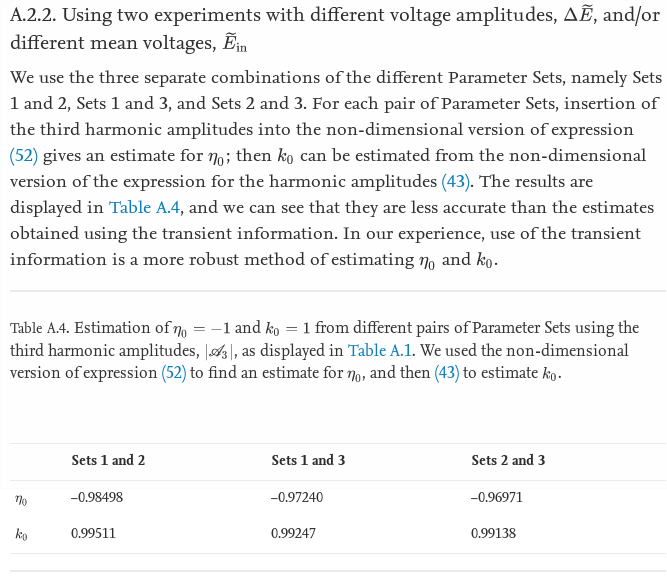

In [12]:
Image(filename="Inferred_param_table.png")